In [1]:
import pyspark
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading CSV file into spark dataframe
df = spark.read.load("./soil_data.csv", format = "csv", header = "true", inferSchema = "true")

In [3]:
#Data Analysis
#Dataframe schema
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- soil_moisture: double (nullable = true)
 |-- soil_temperature: double (nullable = true)
 |-- 454: double (nullable = true)
 |-- 458: double (nullable = true)
 |-- 462: double (nullable = true)
 |-- 466: double (nullable = true)
 |-- 470: double (nullable = true)
 |-- 474: double (nullable = true)
 |-- 478: double (nullable = true)
 |-- 482: double (nullable = true)
 |-- 486: double (nullable = true)
 |-- 490: double (nullable = true)
 |-- 494: double (nullable = true)
 |-- 498: double (nullable = true)
 |-- 502: double (nullable = true)
 |-- 506: double (nullable = true)
 |-- 510: double (nullable = true)
 |-- 514: double (nullable = true)
 |-- 518: double (nullable = true)
 |-- 522: double (nullable = true)
 |-- 526: double (nullable = true)
 |-- 530: double (nullable = true)
 |-- 534: double (nullable = true)
 |-- 538: double (nullable = true)
 |-- 542: double (nullable = true)
 |-- 546: double

In [4]:
#Showing first five rows of the data set
df.show(5)

+-----+-------------------+-------------+----------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------

In [5]:
#Number of data points
df.count()

679

In [6]:
#Summary of every column in the dataframe
for i in df.columns:
    df.describe(i).show()

+-------+-----------------+
|summary|            index|
+-------+-----------------+
|  count|              679|
|   mean|341.5743740795287|
| stddev|196.7314477356998|
|    min|                0|
|    max|              681|
+-------+-----------------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+------------------+
|summary|     soil_moisture|
+-------+------------------+
|  count|               679|
|   mean|31.568335787923413|
| stddev| 3.645354181464279|
|    min|              25.5|
|    max|              42.5|
+-------+------------------+

+-------+-----------------+
|summary| soil_temperature|
+-------+-----------------+
|  count|              679|
|   mean|37.49837997054491|
| stddev| 4.66060313268832|
|    min|             26.4|
|    max|             47.1|
+-------+-----------------+

+-------+--------------------+
|summary|                 454|
+-------+--------------------+
|  count|                 679|
|   mean| 0.10537

+-------+--------------------+
|summary|                 566|
+-------+--------------------+
|  count|                 679|
|   mean| 0.10209060815669387|
| stddev|0.026898142433280026|
|    min| 0.07672866130051373|
|    max| 0.18543862996049024|
+-------+--------------------+

+-------+--------------------+
|summary|                 570|
+-------+--------------------+
|  count|                 679|
|   mean| 0.10440344933059388|
| stddev|0.027438454262044245|
|    min| 0.07835849060919567|
|    max|  0.1896768312340889|
+-------+--------------------+

+-------+--------------------+
|summary|                 574|
+-------+--------------------+
|  count|                 679|
|   mean| 0.10655675688671426|
| stddev|0.027902456109764506|
|    min| 0.08052218076960672|
|    max| 0.19290053681675065|
+-------+--------------------+

+-------+-------------------+
|summary|                578|
+-------+-------------------+
|  count|                679|
|   mean|0.10861719377956501|
| stddev|0

+-------+--------------------+
|summary|                 686|
+-------+--------------------+
|  count|                 679|
|   mean| 0.14871831306708005|
| stddev|0.037937490087938085|
|    min|  0.1100808884850868|
|    max|  0.2607800422315858|
+-------+--------------------+

+-------+-------------------+
|summary|                690|
+-------+-------------------+
|  count|                679|
|   mean| 0.1499415335994332|
| stddev|0.03808773188031174|
|    min|0.11111412637891968|
|    max| 0.2612692109713949|
+-------+-------------------+

+-------+--------------------+
|summary|                 694|
+-------+--------------------+
|  count|                 679|
|   mean| 0.15106061797380108|
| stddev|0.038039298094533616|
|    min| 0.11187843429889424|
|    max|  0.2621084528971556|
+-------+--------------------+

+-------+--------------------+
|summary|                 698|
+-------+--------------------+
|  count|                 679|
|   mean| 0.15227327691549028|
| stddev|0.037

+-------+-------------------+
|summary|                806|
+-------+-------------------+
|  count|                679|
|   mean|0.18051630292319798|
| stddev|0.04015210956409007|
|    min| 0.1402675497843043|
|    max| 0.2998991984336987|
+-------+-------------------+

+-------+-------------------+
|summary|                810|
+-------+-------------------+
|  count|                679|
|   mean| 0.1808301835933824|
| stddev|0.04020599643744258|
|    min| 0.1413497751981217|
|    max| 0.3003739487239181|
+-------+-------------------+

+-------+-------------------+
|summary|                814|
+-------+-------------------+
|  count|                679|
|   mean| 0.1811008373831283|
| stddev|0.04024323899710108|
|    min|0.14149182168682448|
|    max| 0.3002780824444077|
+-------+-------------------+

+-------+--------------------+
|summary|                 818|
+-------+--------------------+
|  count|                 679|
|   mean| 0.18132802220412814|
| stddev|0.040219494141789804|
|

+-------+-------------------+
|summary|                938|
+-------+-------------------+
|  count|                679|
|   mean|0.18765156989793585|
| stddev|0.03893504794233682|
|    min|0.14276792654650305|
|    max|0.29932831036531204|
+-------+-------------------+

+-------+-------------------+
|summary|                942|
+-------+-------------------+
|  count|                679|
|   mean|0.18753576966972785|
| stddev|0.03904471005036974|
|    min|0.14199688748490194|
|    max|0.29877810137412986|
+-------+-------------------+

+-------+-------------------+
|summary|                946|
+-------+-------------------+
|  count|                679|
|   mean| 0.1873087849356241|
| stddev|0.03915574889439407|
|    min|0.14054657106907573|
|    max| 0.2986453218683756|
+-------+-------------------+

+-------+-------------------+
|summary|                950|
+-------+-------------------+
|  count|                679|
|   mean|0.18704470585782068|
| stddev|0.03937051070994474|
|    mi

In [7]:
#Column index doesn't effect the soil moisture and soil temperature and colum datetime has all the values as Null so there is nothing we can do about it so dropping them.
df = df.drop("index", "datetime")

In [8]:
#Checking for Null values in the dataset
for i in df.columns:
    print("null values in ",i," : ", df.filter(df[i].isNull()).count())

null values in  soil_moisture  :  0
null values in  soil_temperature  :  0
null values in  454  :  0
null values in  458  :  0
null values in  462  :  0
null values in  466  :  0
null values in  470  :  0
null values in  474  :  0
null values in  478  :  0
null values in  482  :  0
null values in  486  :  0
null values in  490  :  0
null values in  494  :  0
null values in  498  :  0
null values in  502  :  0
null values in  506  :  0
null values in  510  :  0
null values in  514  :  0
null values in  518  :  0
null values in  522  :  0
null values in  526  :  0
null values in  530  :  0
null values in  534  :  0
null values in  538  :  0
null values in  542  :  0
null values in  546  :  0
null values in  550  :  0
null values in  554  :  0
null values in  558  :  0
null values in  562  :  0
null values in  566  :  0
null values in  570  :  0
null values in  574  :  0
null values in  578  :  0
null values in  582  :  0
null values in  586  :  0
null values in  590  :  0
null values in 

In [9]:
#There are no null values so no need for replacing data. We continue by checking the data plots
mois = df.select('soil_moisture').rdd.flatMap(lambda x : x).collect()
temp = df.select('soil_temperature').rdd.flatMap(lambda x : x).collect()

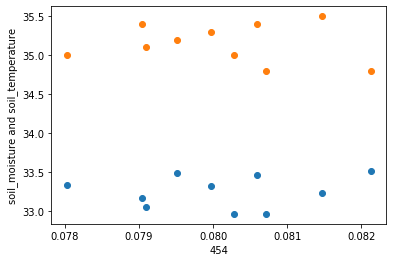

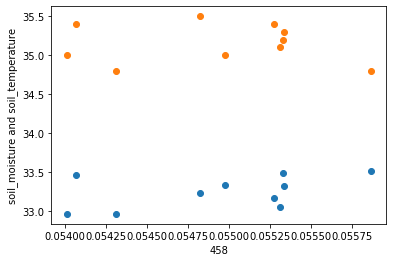

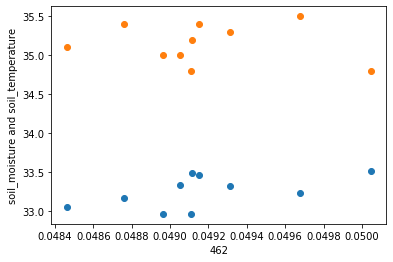

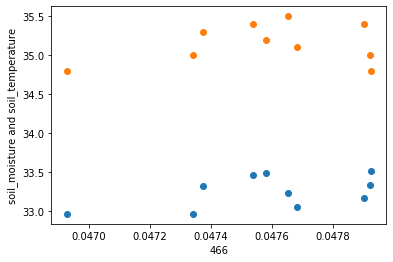

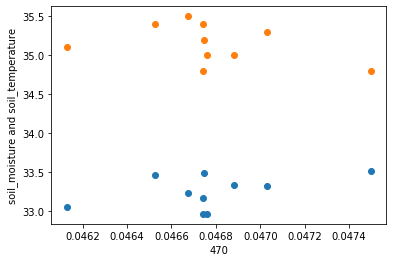

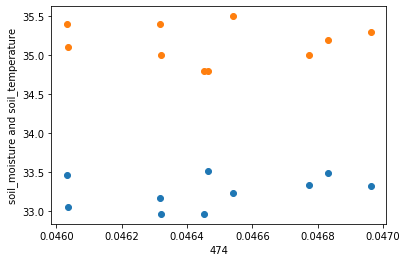

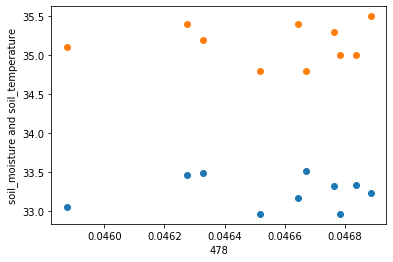

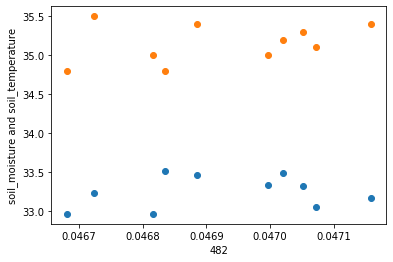

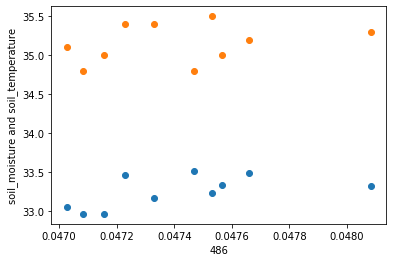

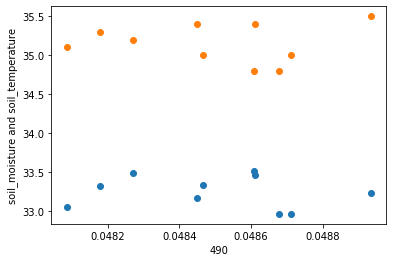

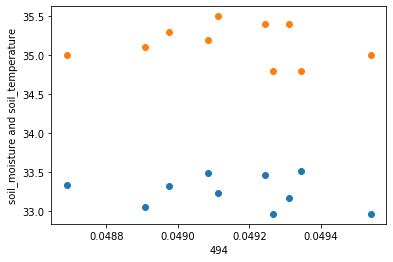

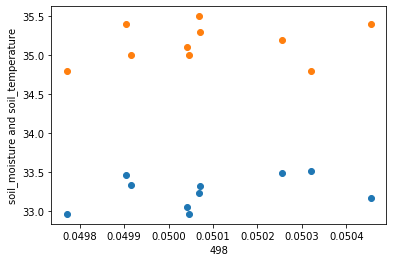

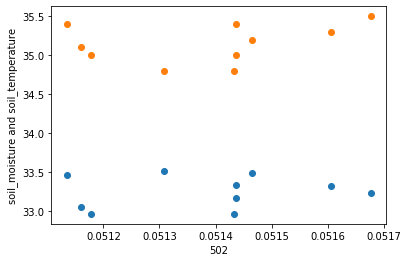

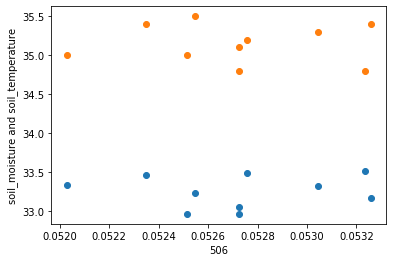

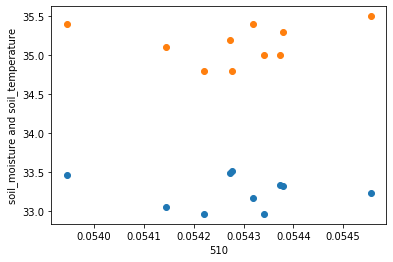

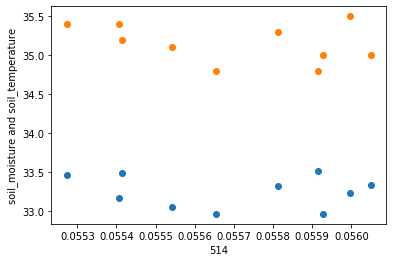

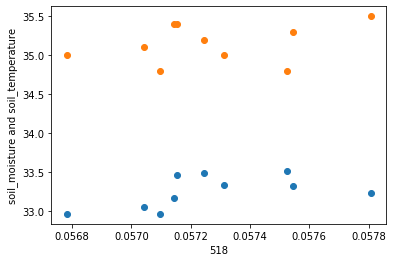

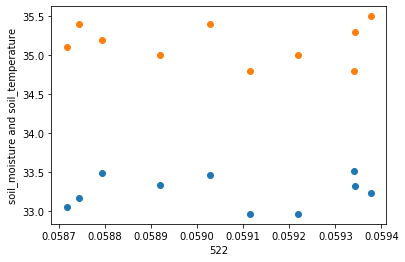

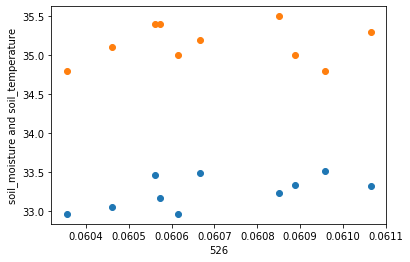

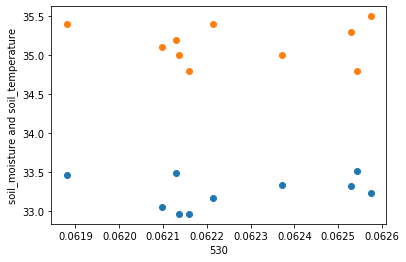

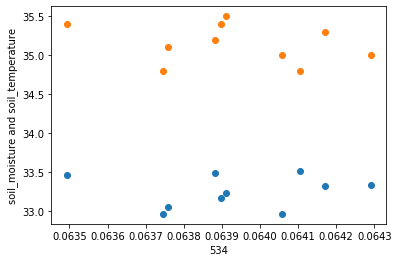

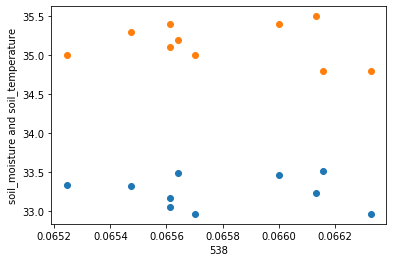

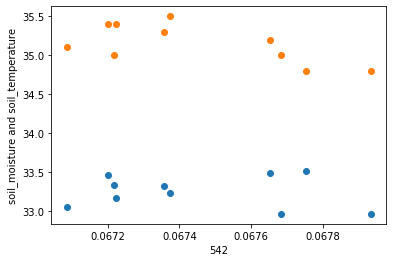

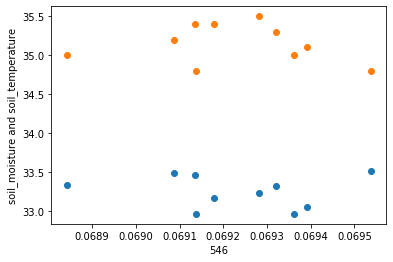

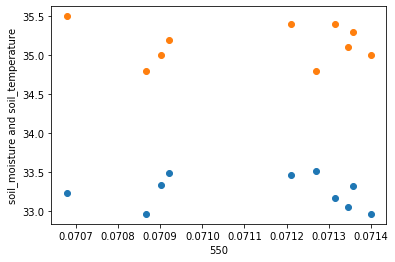

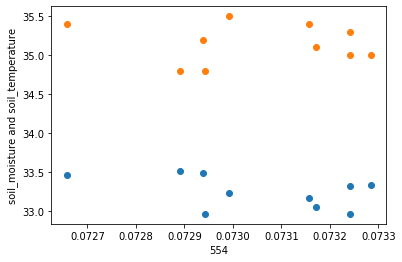

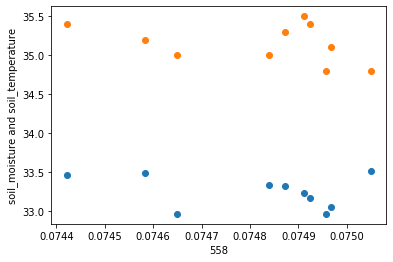

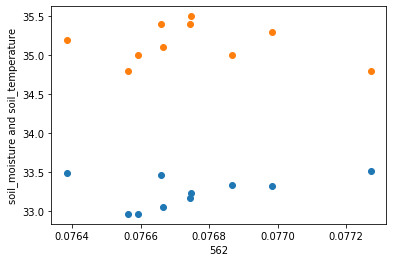

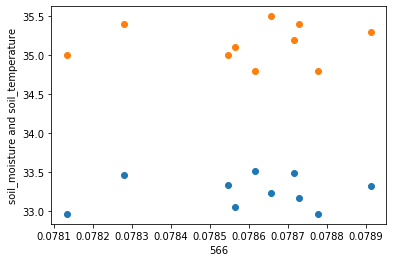

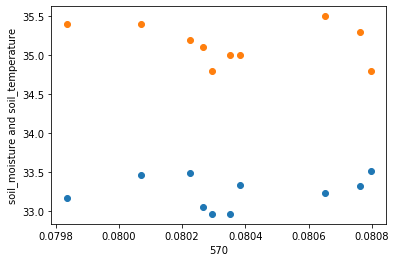

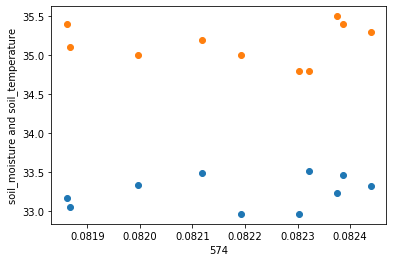

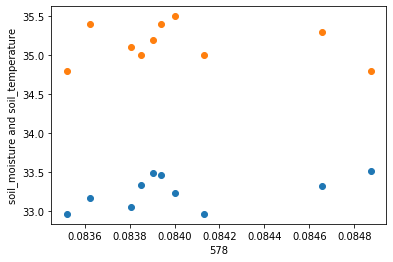

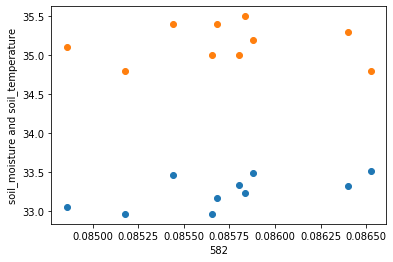

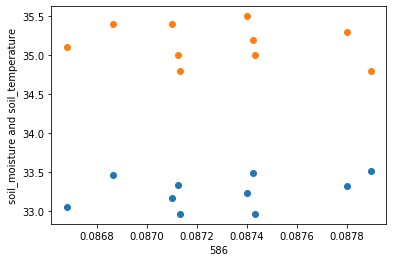

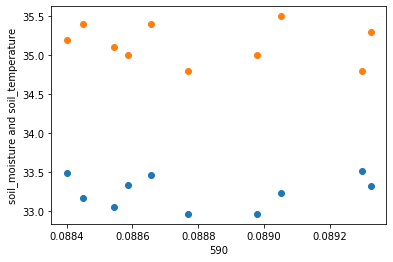

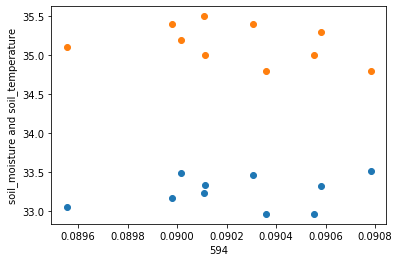

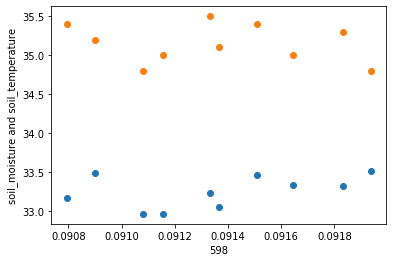

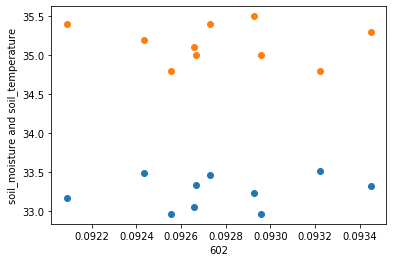

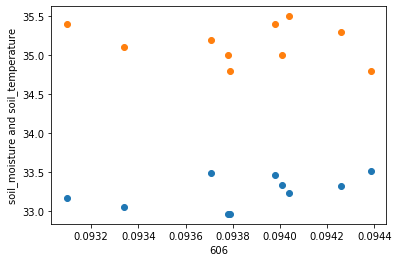

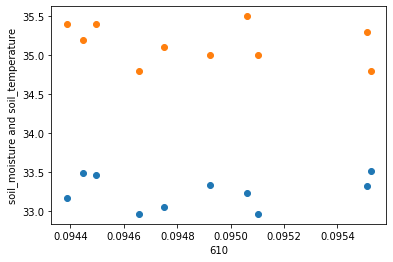

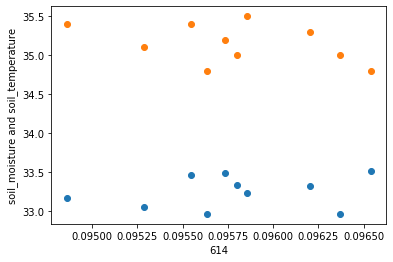

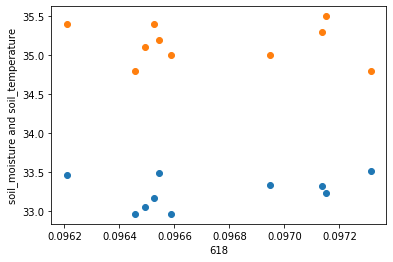

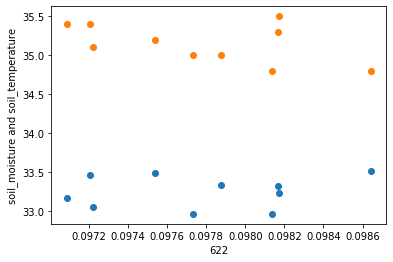

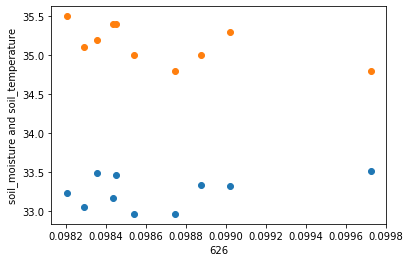

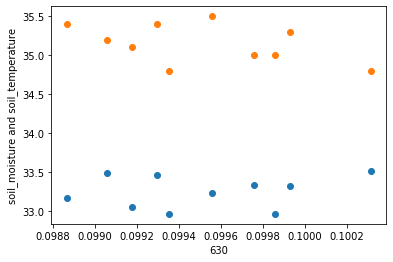

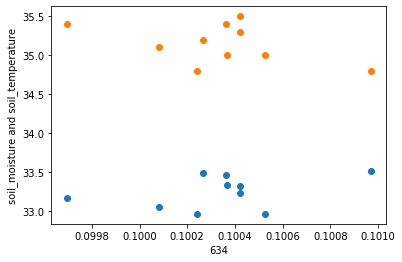

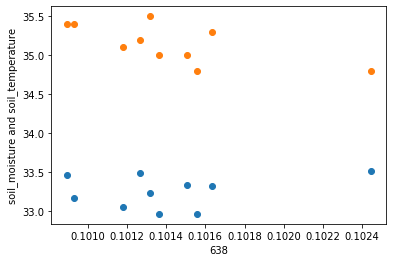

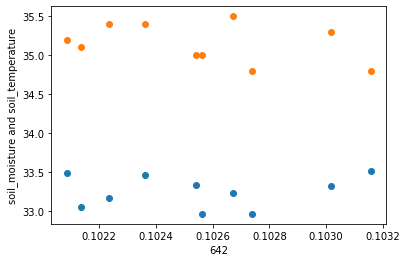

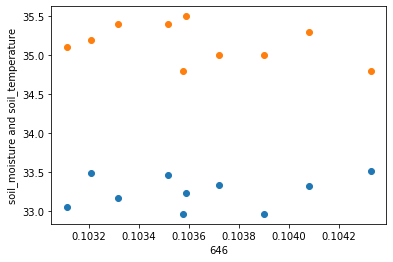

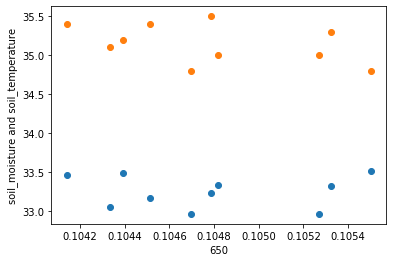

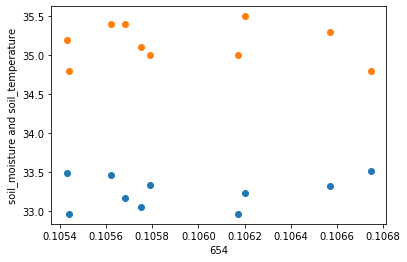

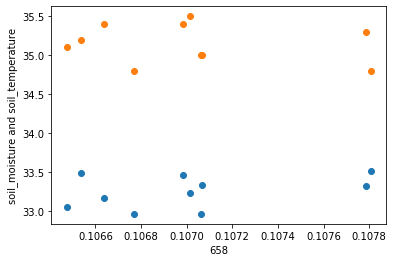

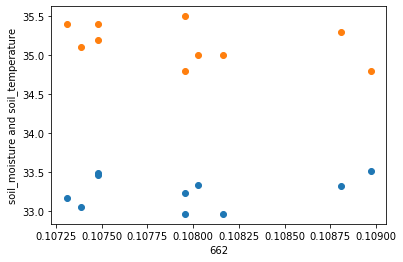

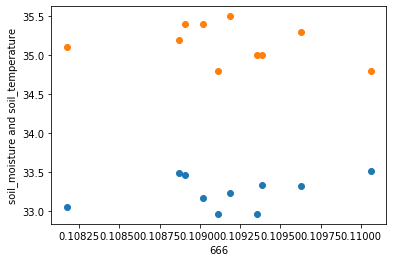

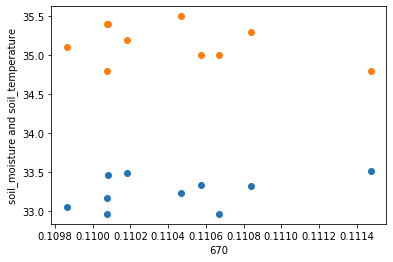

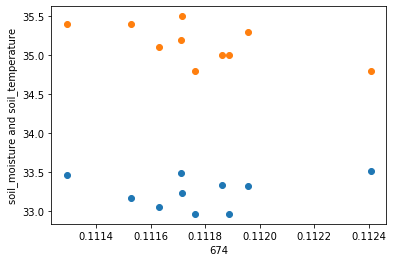

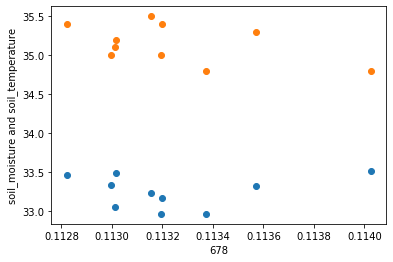

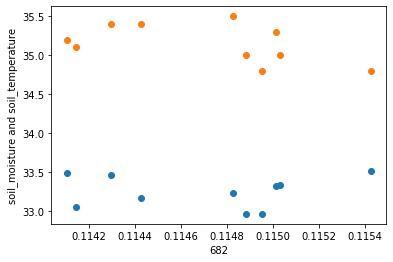

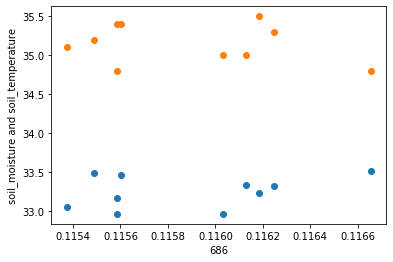

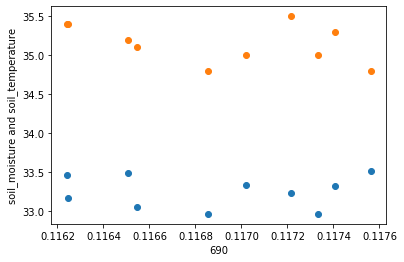

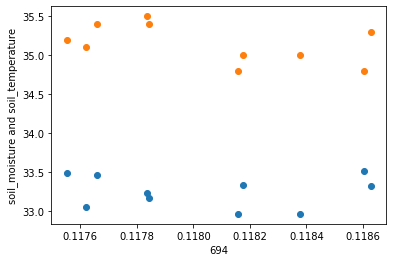

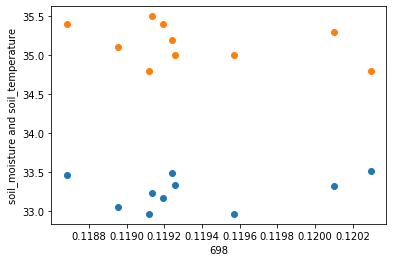

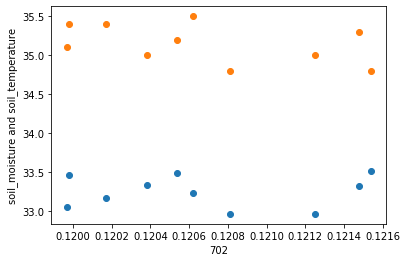

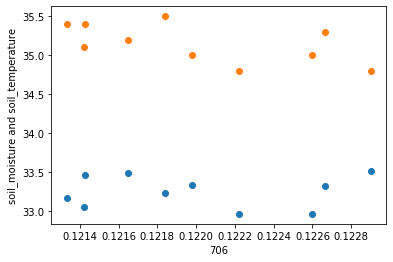

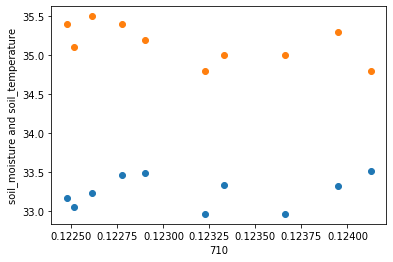

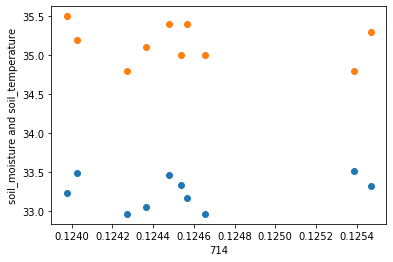

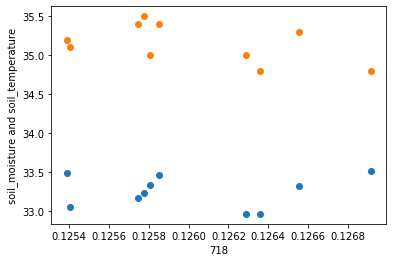

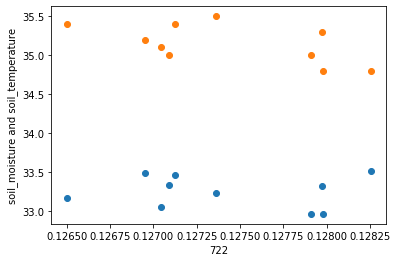

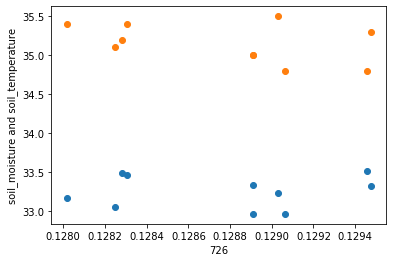

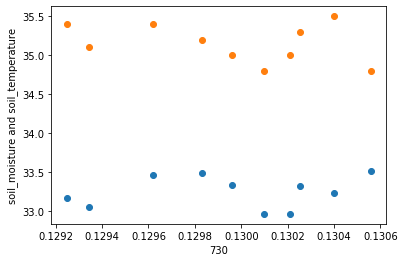

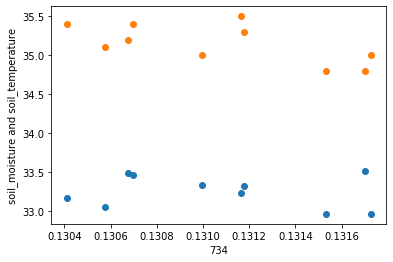

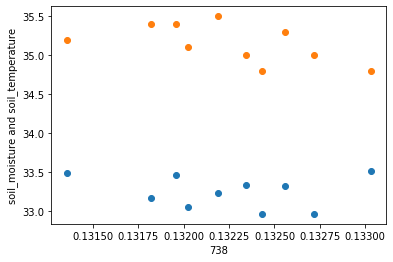

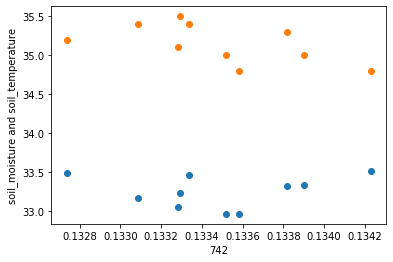

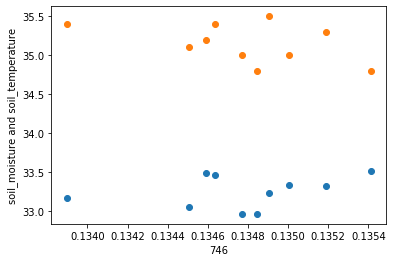

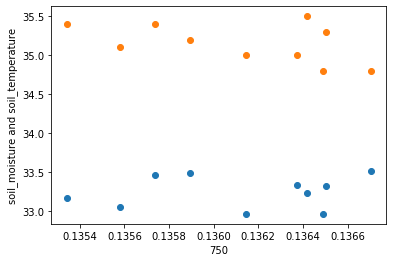

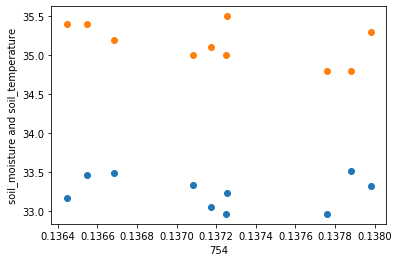

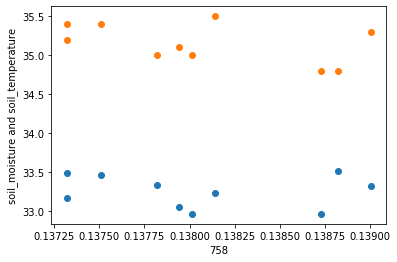

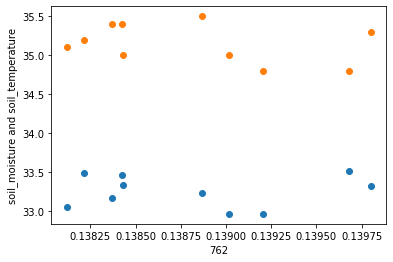

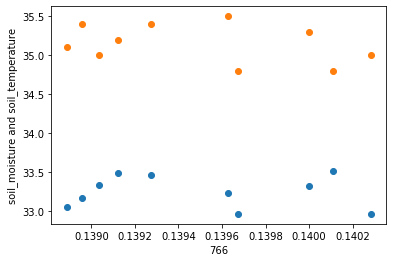

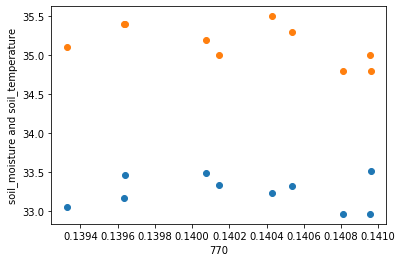

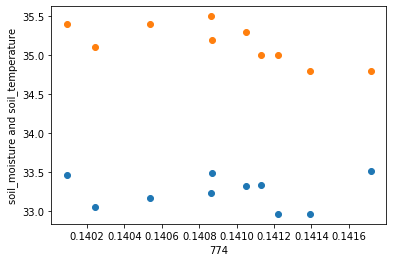

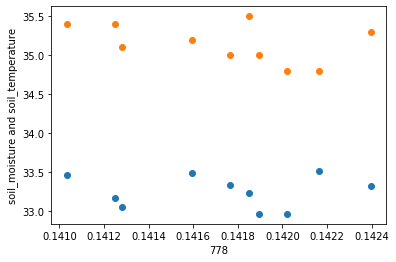

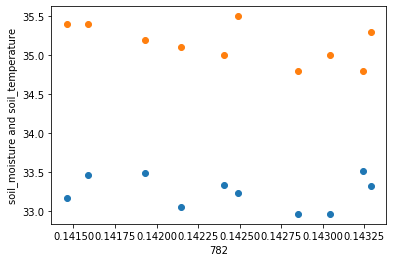

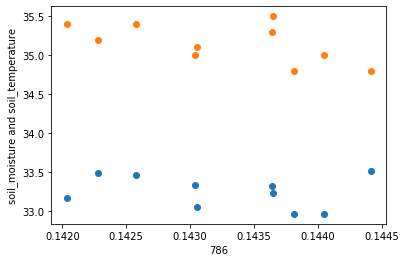

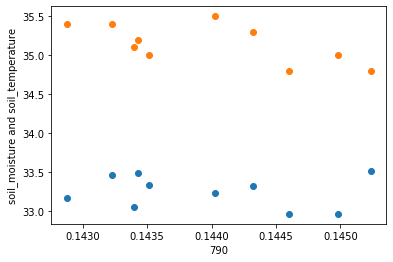

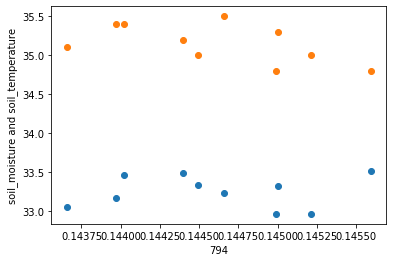

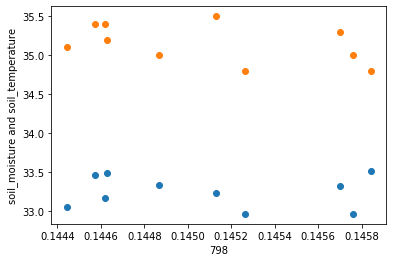

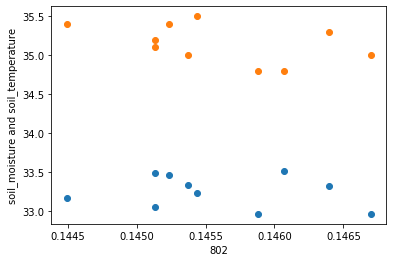

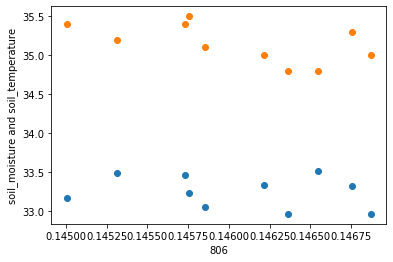

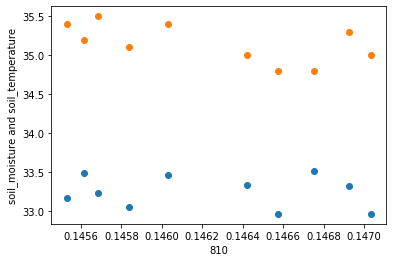

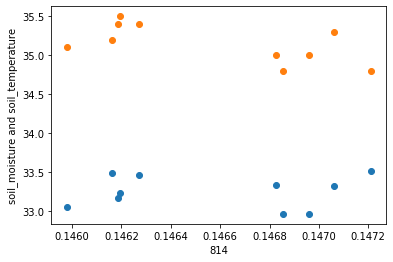

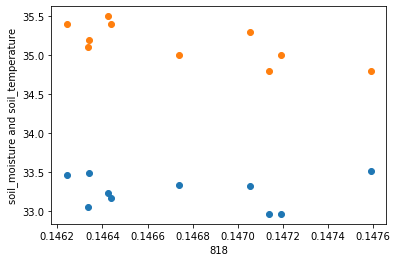

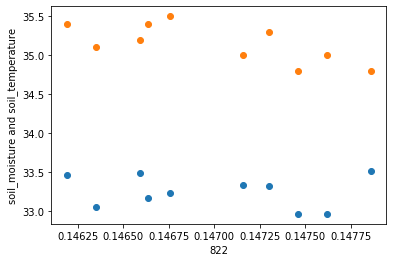

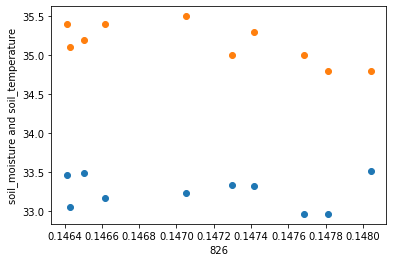

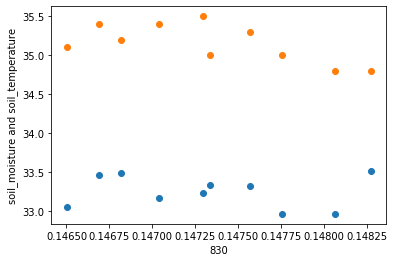

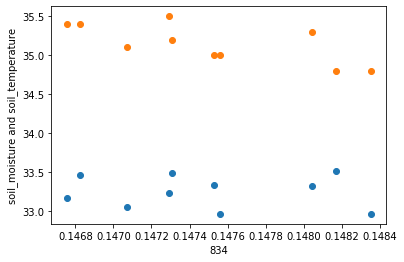

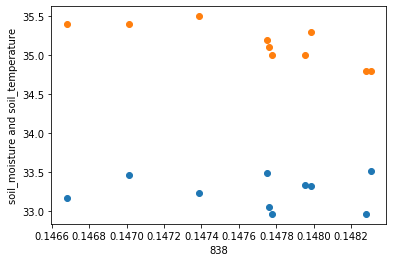

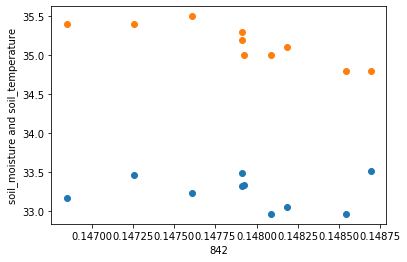

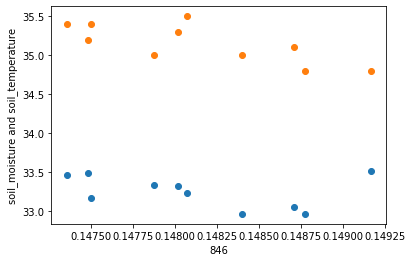

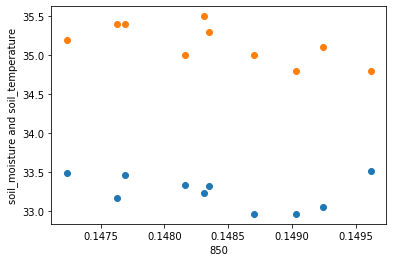

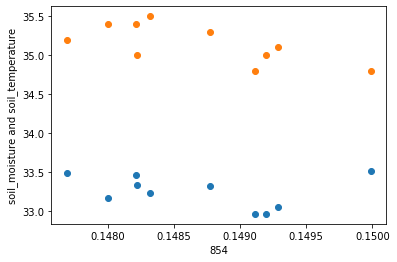

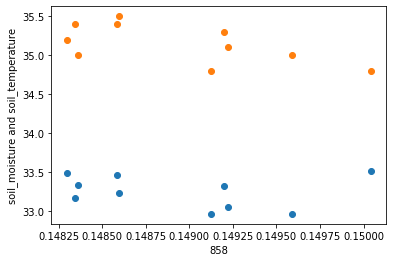

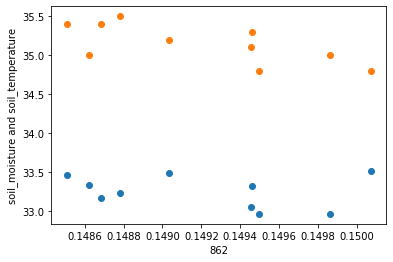

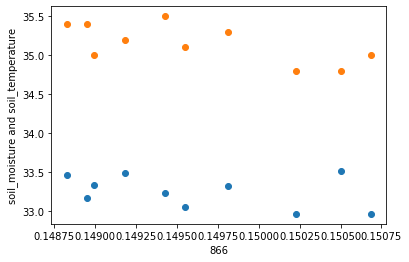

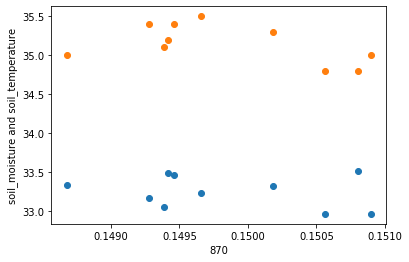

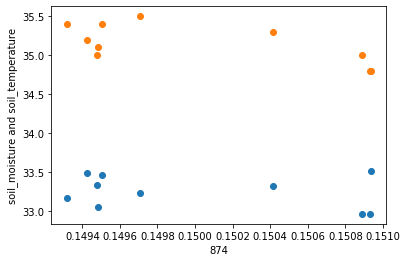

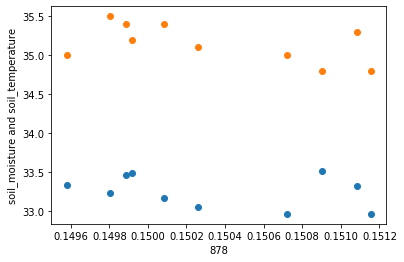

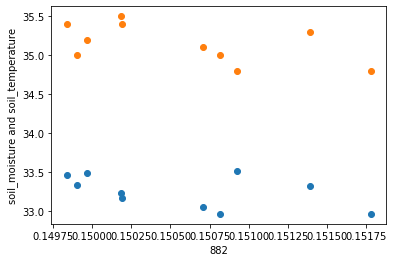

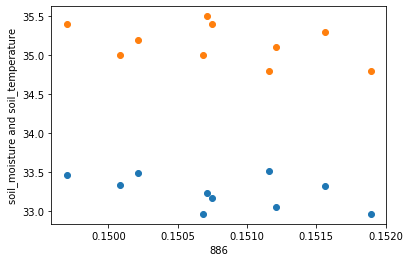

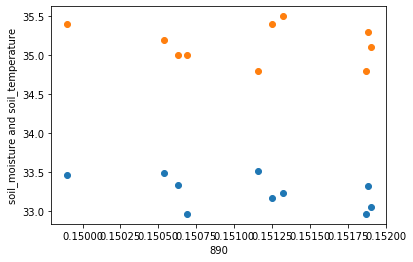

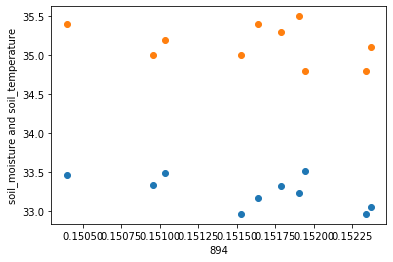

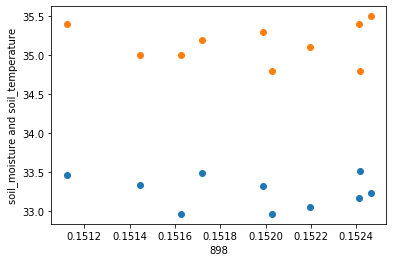

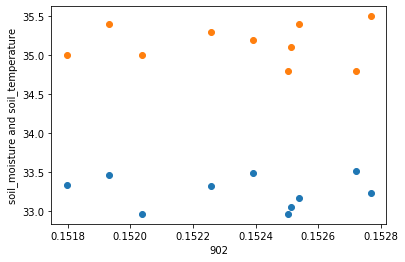

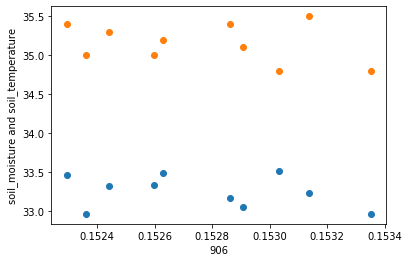

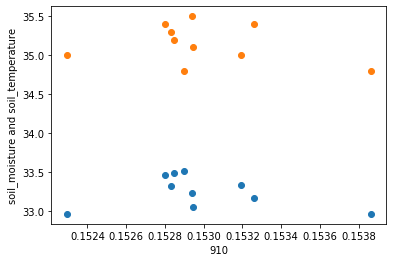

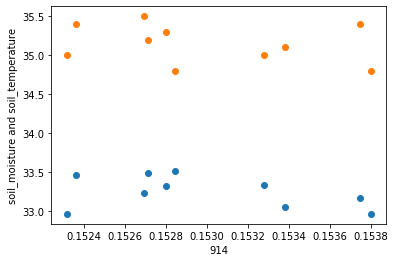

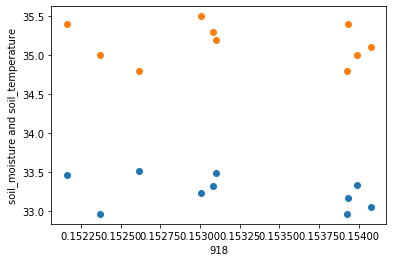

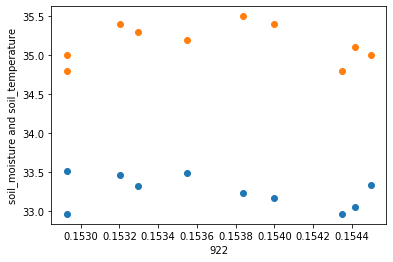

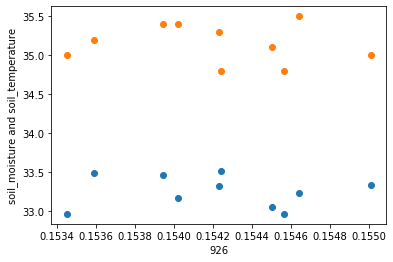

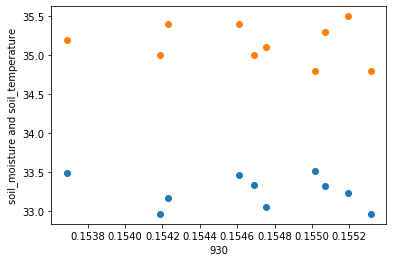

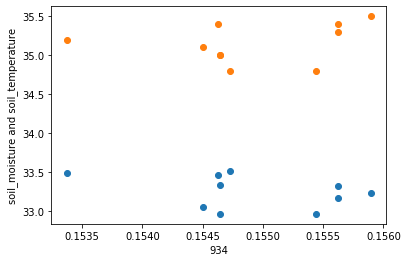

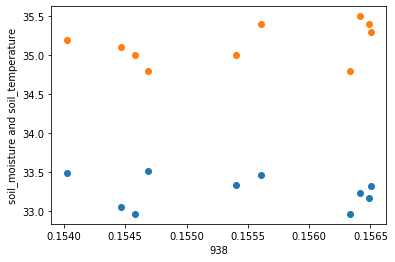

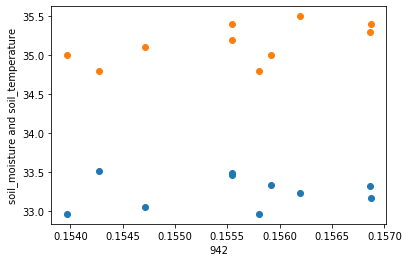

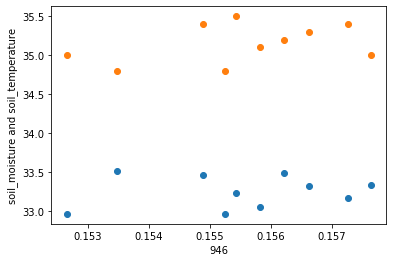

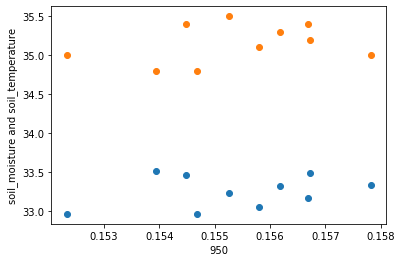

In [10]:
#Visualization of data
for i in df.columns[2:]:
    b = df.select(i).rdd.flatMap(lambda x: x).collect()
    plt.plot(b[0:10], mois[0:10],'o')
    plt.plot(b[0:10], temp[0:10],'o')
    plt.xlabel(i)
    plt.ylabel("soil_moisture and soil_temperature")
    plt.show()

In [11]:
#After looking at means of bandwiths and data plots and also by referring the https://www.researchgate.net/figure/Transmission-spectrum-of-the-water-sample-measured-using-UV-Vis-spectrophotometer_fig2_310823463 it is concluded that the water content is not seen effected in the region 395nm - 670nm and is constant and there won't be any data loss if drop these columns and to visualize we can performing Principal Component Analysis as the remaining bandwidths as they are correlated we have to find out the correlation between Soil Moisture, Soil Temperature and Bandwidths
#Reference : https://spark.apache.org/docs/2.2.0/ml-statistics.html
print("Correlation to Soil Moisture for Soil Temperature ",df.stat.corr('soil_moisture', 'soil_temperature'))
for i in df.columns[2:]:
    print("Correlation to Soil Moisture for ", i, df.stat.corr('soil_moisture', i))
    print("Correlation to Soil Temperature for ", i, df.stat.corr('soil_temperature', i))

Correlation to Soil Moisture for Soil Temperature  -0.7924512320665361
Correlation to Soil Moisture for  454 -0.68464353924301
Correlation to Soil Temperature for  454 0.6570490434206713
Correlation to Soil Moisture for  458 -0.6566842647123694
Correlation to Soil Temperature for  458 0.5894129997532919
Correlation to Soil Moisture for  462 -0.6485693079310291
Correlation to Soil Temperature for  462 0.5556178512720275
Correlation to Soil Moisture for  466 -0.6568421035616981
Correlation to Soil Temperature for  466 0.5476263759828514
Correlation to Soil Moisture for  470 -0.6546444116747379
Correlation to Soil Temperature for  470 0.5378368850499435
Correlation to Soil Moisture for  474 -0.6573370091999691
Correlation to Soil Temperature for  474 0.5357292897132211
Correlation to Soil Moisture for  478 -0.6586948036818706
Correlation to Soil Temperature for  478 0.5340645382631255
Correlation to Soil Moisture for  482 -0.6564469517107351
Correlation to Soil Temperature for  482 0.5288

Correlation to Soil Temperature for  734 0.6309138251203629
Correlation to Soil Moisture for  738 -0.7516625735217946
Correlation to Soil Temperature for  738 0.6317210031067051
Correlation to Soil Moisture for  742 -0.7525832913584259
Correlation to Soil Temperature for  742 0.6313566805961777
Correlation to Soil Moisture for  746 -0.752650300324954
Correlation to Soil Temperature for  746 0.6308703898645449
Correlation to Soil Moisture for  750 -0.7529533105819444
Correlation to Soil Temperature for  750 0.6302689553011385
Correlation to Soil Moisture for  754 -0.7549260090778163
Correlation to Soil Temperature for  754 0.631414031590127
Correlation to Soil Moisture for  758 -0.7587625246173633
Correlation to Soil Temperature for  758 0.6336117927088254
Correlation to Soil Moisture for  762 -0.7629697262569147
Correlation to Soil Temperature for  762 0.634626579387894
Correlation to Soil Moisture for  766 -0.7660590471264779
Correlation to Soil Temperature for  766 0.6342456837078428

In [12]:
#We can see that Soil Moisture and Soil Temperature are negatively correlated which means as temperature increases moisture decreases, Soil Moisture and Bandwidths are negatively correlated and Soil Temperature and Bandwidths are positively correlated so droping the Columns which make less effect
df = df.drop(*[i for i in df.columns[2:] if int(i) >= 395 and int(i) <= 670])

In [13]:
#As we can see visualization is harder with more than 3 dimensions of data and Collecting all the rows of bandwidths into a matrix
#Reference : https://spark.apache.org/docs/latest/ml-features#vectorassembler
bandwidth_vector = VectorAssembler(inputCols=df.columns[2:], outputCol = 'bandwidth_vector').transform(df).select(['bandwidth_vector', 'soil_moisture'])
bandwidth_vector.show()

+--------------------+-------------+
|    bandwidth_vector|soil_moisture|
+--------------------+-------------+
|[0.11240779170117...|        33.51|
|[0.11171016358718...|        33.49|
|[0.11129123178626...|        33.46|
|[0.11185990892114...|        33.33|
|[0.11195497416603...|        33.32|
|[0.11171383175162...|        33.23|
|[0.11152710898834...|        33.16|
|[0.11163119876876...|        33.05|
|[0.11188776980464...|        32.96|
|[0.11176166929305...|        32.96|
|[0.11223397614781...|        32.95|
|[0.11306221985608...|        32.84|
|[0.11258029456686...|        32.85|
|[0.11253460024184...|        32.72|
|[0.11272422824430...|        32.78|
|[0.11259693495528...|        32.76|
|[0.11299465823612...|        32.74|
|[0.11385203499571...|        32.61|
|[0.11339976717296...|        32.66|
|[0.11415772938181...|         32.5|
+--------------------+-------------+
only showing top 20 rows



In [14]:
#Normalizing the data such that Mean is 0 and Standard Deviation is 1 because their ranges are different from each other
#Reference : https://spark.apache.org/docs/latest/ml-features#standardscaler
bandwidth_scaled = StandardScaler(inputCol = 'bandwidth_vector', outputCol = 'bandwidth_scaled', withStd = True, withMean = False).fit(bandwidth_vector).transform(bandwidth_vector).select(['bandwidth_vector', 'bandwidth_scaled'])
bandwidth_scaled.show()

+--------------------+--------------------+
|    bandwidth_vector|    bandwidth_scaled|
+--------------------+--------------------+
|[0.11240779170117...|[3.06726973468146...|
|[0.11171016358718...|[3.04823356674581...|
|[0.11129123178626...|[3.03680218094597...|
|[0.11185990892114...|[3.05231966543882...|
|[0.11195497416603...|[3.05491370935751...|
|[0.11171383175162...|[3.04833365989403...|
|[0.11152710898834...|[3.04323855863897...|
|[0.11163119876876...|[3.04607885492399...|
|[0.11188776980464...|[3.05307990495130...|
|[0.11176166929305...|[3.04963900217312...|
|[0.11223397614781...|[3.06252683227078...|
|[0.11306221985608...|[3.08512710597847...|
|[0.11258029456686...|[3.07197681780345...|
|[0.11253460024184...|[3.07072995743836...|
|[0.11272422824430...|[3.07590433391158...|
|[0.11259693495528...|[3.07243088383370...|
|[0.11299465823612...|[3.08328355306292...|
|[0.11385203499571...|[3.10667877990714...|
|[0.11339976717296...|[3.09433775457689...|
|[0.11415772938181...|[3.1150202

In [15]:
#Performing Principal Component Analysis by computing the Eigen Vectors of the Matrix and taking the top one from them
#Reference : https://spark.apache.org/docs/2.2.0/ml-features.html#pca
bandwidth = PCA(k = 1, inputCol='bandwidth_scaled', outputCol='bandwidth').fit(bandwidth_scaled).transform(bandwidth_scaled).select('bandwidth')
bandwidth.show()

+--------------------+
|           bandwidth|
+--------------------+
|[-30.313259108046...|
|[-30.11353540946921]|
|[-30.090382036176...|
|[-30.19628691922226]|
|[-30.293219553224...|
|[-30.199967285287...|
|[-30.13209405877572]|
|[-30.157943950252...|
|[-30.225989892838...|
|[-30.286251051701...|
|[-30.297029461692...|
|[-30.501008811295...|
|[-30.442601757302...|
|[-30.36093887826493]|
|[-30.51690895337983]|
|[-30.575470417045...|
|[-30.663846245589...|
|[-30.713457670857...|
|[-30.637473896996...|
|[-30.814650545948...|
+--------------------+
only showing top 20 rows



In [16]:
#Converting bandwidth from vector to list
bw = bandwidth.select('bandwidth').rdd.flatMap(lambda x : np.array(x).tolist()[0]).collect()

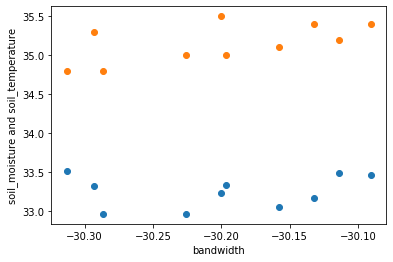

In [17]:
#Visualization of data
plt.plot(bw[0:10], mois[0:10], 'o')
plt.plot(bw[0:10], temp[0:10], 'o')
plt.xlabel('bandwidth')
plt.ylabel('soil_moisture and soil_temperature')
plt.show()

In [18]:
#Regression
#Training Data and Testing Data
data = bandwidth_vector.randomSplit([0.7, 0.3])
train_data = data[0]
test_data = data[1]

In [19]:
#Linear Regression Y =B0 + B1 . X where, X has all the data from Independent Variables [bandwidths from 674 to 950] and Y data has all the data from Dependent Variable [soil_moisture]. We are Obtaining Coefficients and Intercept
#Reference : https://spark.apache.org/docs/2.1.1/ml-classification-regression.html#linear-regression
lr = LinearRegression(featuresCol = 'bandwidth_vector', labelCol = 'soil_moisture', maxIter = 10, regParam = 0.3, elasticNetParam = 0.8).fit(train_data)
print("Coefficients : ", lr.coefficients)
print("Intercept : ", lr.intercept)

Coefficients :  [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5987290661903865,-1.0014367219912992,-1.0833731477116721,-1.1027548763809434,-1.0938214714851937,-1.0922279151593597,-1.1197179518644746,-1.1318922309322677,-1.107555743726997,-1.0687681589610836,-1.0428178784524316,-1.0366079511453428,-1.0692014516406623,-1.115420494522897,-1.1424000157073282,-1.139537384201651,-1.1510992308094086,-1.1607891650644802,-1.1812377624966761,-1.1982053491420055,-1.203523470151923,-1.196099846433808,-1.175967822028467,-1.163434019719058,-1.1519420277877614,-1.126450791500192,-1.110920119857156,-1.1053019842774228,-1.1031101007464859,-1.1074371248733086,-1.1131337957083316,-1.1248441390339778,-1.1531846563990658,-1.176228017082484,-1.1887392143992297,-1.212570418276881,-1.230949370975953,-1.2385113037197946,-1.2496197565422555,-1.2861611447024923,-1.372052756321678,-1.40413310733915,-1.452314277895734,-1.6829536089728494,-1.7932577321666157,-2.280305851244

In [20]:
#Even after dropping the Data with less effect we still got some coefficients zero
#Predicting Data
pred = lr.transform(test_data)
pred.show()

+--------------------+-------------+------------------+
|    bandwidth_vector|soil_moisture|        prediction|
+--------------------+-------------+------------------+
|[0.10867604500564...|        33.54|33.941870869993096|
|[0.10951973339760...|        33.98| 33.91544042461185|
|[0.10967775168405...|        32.37|33.673875657980076|
|[0.11014796819787...|        32.27|33.758446073678755|
|[0.11015942733774...|        32.82| 33.66439132137348|
|[0.11033329835973...|        32.23| 33.60028335400429|
|[0.11037254067502...|        32.27| 33.62763864198195|
|[0.11055966646418...|         31.8| 33.44387394724653|
|[0.11074683618286...|        31.84|33.503356321907056|
|[0.11081101722569...|        32.02|33.518676513004735|
|[0.11091357857468...|        33.65|33.831226898012694|
|[0.11099842271798...|        33.85| 33.89035210948223|
|[0.11100586086039...|        33.52|33.635676282701226|
|[0.11105389221556...|        34.32|33.840036779672175|
|[0.11109173964605...|        33.57|33.612373321

In [21]:
#Computing R squared value for Linear Regression
#Reference : https://spark.apache.org/docs/1.6.2/api/java/org/apache/spark/ml/evaluation/RegressionEvaluator.html
rsquare = RegressionEvaluator(predictionCol = "prediction", labelCol = "soil_moisture", metricName = "r2")
print("R squared value of Linear Regression Prediction is ", rsquare.evaluate(pred))

R squared value of Linear Regression Prediction is  0.5720304957173366


In [22]:
#Decision Tree Regression
#Reference : https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-trees
dt = DecisionTreeRegressor(featuresCol = "bandwidth_vector", labelCol = "soil_moisture").fit(train_data)

In [23]:
#Predicting Data
dt_pred = dt.transform(test_data)
dt_pred.show()

+--------------------+-------------+------------------+
|    bandwidth_vector|soil_moisture|        prediction|
+--------------------+-------------+------------------+
|[0.10867604500564...|        33.54|33.902089552238806|
|[0.10951973339760...|        33.98|33.902089552238806|
|[0.10967775168405...|        32.37|       31.77703125|
|[0.11014796819787...|        32.27|33.902089552238806|
|[0.11015942733774...|        32.82|       31.77703125|
|[0.11033329835973...|        32.23|       31.77703125|
|[0.11037254067502...|        32.27|       31.77703125|
|[0.11055966646418...|         31.8|33.902089552238806|
|[0.11074683618286...|        31.84|       31.77703125|
|[0.11081101722569...|        32.02|       31.77703125|
|[0.11091357857468...|        33.65|33.902089552238806|
|[0.11099842271798...|        33.85|33.902089552238806|
|[0.11100586086039...|        33.52|       31.77703125|
|[0.11105389221556...|        34.32|33.902089552238806|
|[0.11109173964605...|        33.57|       31.77

In [24]:
#Computing R squared value for Decision Tree Regression
rsquare = RegressionEvaluator(predictionCol = "prediction", labelCol = "soil_moisture", metricName = "r2")
print("R squared value of Decision Tree Regression Pediction is ", rsquare.evaluate(dt_pred)) 

R squared value of Decision Tree Regression Pediction is  0.8476458955282139


In [25]:
#Gradient Boosted Tree Regression
#Reference : https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-regression
gbt = GBTRegressor(featuresCol = "bandwidth_vector", labelCol = "soil_moisture", maxIter = 10).fit(train_data)

In [26]:
#Predicting Data
gbt_pred = gbt.transform(test_data)
gbt_pred.show()

+--------------------+-------------+------------------+
|    bandwidth_vector|soil_moisture|        prediction|
+--------------------+-------------+------------------+
|[0.10867604500564...|        33.54| 33.97218761782953|
|[0.10951973339760...|        33.98| 33.98432103354785|
|[0.10967775168405...|        32.37| 32.00693092096844|
|[0.11014796819787...|        32.27| 33.34295812122498|
|[0.11015942733774...|        32.82| 32.00693092096844|
|[0.11033329835973...|        32.23|31.889203777858114|
|[0.11037254067502...|        32.27|31.889203777858114|
|[0.11055966646418...|         31.8|34.182700653523305|
|[0.11074683618286...|        31.84|31.660362084899184|
|[0.11081101722569...|        32.02|31.660362084899184|
|[0.11091357857468...|        33.65| 33.79138290892705|
|[0.11099842271798...|        33.85| 33.98432103354785|
|[0.11100586086039...|        33.52|32.025570716945055|
|[0.11105389221556...|        34.32| 33.85437080751139|
|[0.11109173964605...|        33.57|32.498863207

In [27]:
#Computing R squared value for Gradient Boosted Tree Regression
rsquare = RegressionEvaluator(predictionCol = "prediction", labelCol = "soil_moisture", metricName = "r2")
print("R squared value of Gradient Boosted Tree Regression Prediction is ", rsquare.evaluate(gbt_pred))

R squared value of Gradient Boosted Tree Regression Prediction is  0.8652937956643061


In [28]:
#Conclusion after proper analysis and modeling of data we can say that Gradient Boosted Tree Regression is best suitable for this data than Linear Regression and Decision Tree Regression
print("R squared value of Linear Regression Prediction is ", rsquare.evaluate(pred), "R squared value of Decision Tree Regression Pediction is ", rsquare.evaluate(dt_pred), "R squared value of Gradient Boosted Tree Regression Prediction is ", rsquare.evaluate(gbt_pred))

R squared value of Linear Regression Prediction is  0.5720304957173366 R squared value of Decision Tree Regression Pediction is  0.8476458955282139 R squared value of Gradient Boosted Tree Regression Prediction is  0.8652937956643061
